In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import os, glob
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, euclidean
from scipy import stats
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

# import the necessary packages
from skimage import feature, io, color
from scipy.stats import moment, describe
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import statsmodels.api as smapi
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.formula.api as smfapi
import statsmodels.api as smapi

from Utils.DataUtils import *
from Utils.UtilsViz import *
from Utils.pipeline_utils import *


In [2]:
os.listdir(os.getcwd())
data = pd.read_csv("./train_na_cleaned.csv", index_col="Id")

data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace(".", "_")
data.columns = data.columns.str.replace("&", "_")
data.columns = ["col_"+c if "SalePrice" not in c else c for c in data.columns ]

display(data.shape, data.head())

(1460, 76)

,col_MSSubClass,col_MSZoning,col_LotFrontage,col_LotArea,col_Street,col_LotShape,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_OverallQual,col_OverallCond,col_YearBuilt,col_YearRemodAdd,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_MasVnrArea,col_ExterQual,col_ExterCond,col_Foundation,col_BsmtQual,col_BsmtCond,col_BsmtExposure,col_BsmtFinType1,col_BsmtFinSF1,col_BsmtFinType2,col_BsmtFinSF2,col_BsmtUnfSF,col_TotalBsmtSF,col_Heating,col_HeatingQC,col_CentralAir,col_Electrical,col_1stFlrSF,col_2ndFlrSF,col_LowQualFinSF,col_GrLivArea,col_BsmtFullBath,col_BsmtHalfBath,col_FullBath,col_HalfBath,col_BedroomAbvGr,col_KitchenAbvGr,col_KitchenQual,col_TotRmsAbvGrd,col_Functional,col_Fireplaces,col_FireplaceQu,col_GarageType,col_GarageYrBlt,col_GarageFinish,col_GarageCars,col_GarageArea,col_GarageQual,col_GarageCond,col_PavedDrive,col_WoodDeckSF,col_OpenPorchSF,col_EnclosedPorch,col_3SsnPorch,col_ScreenPorch,col_PoolArea,col_MiscVal,col_MoSold,col_YrSold,col_SaleType,col_SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


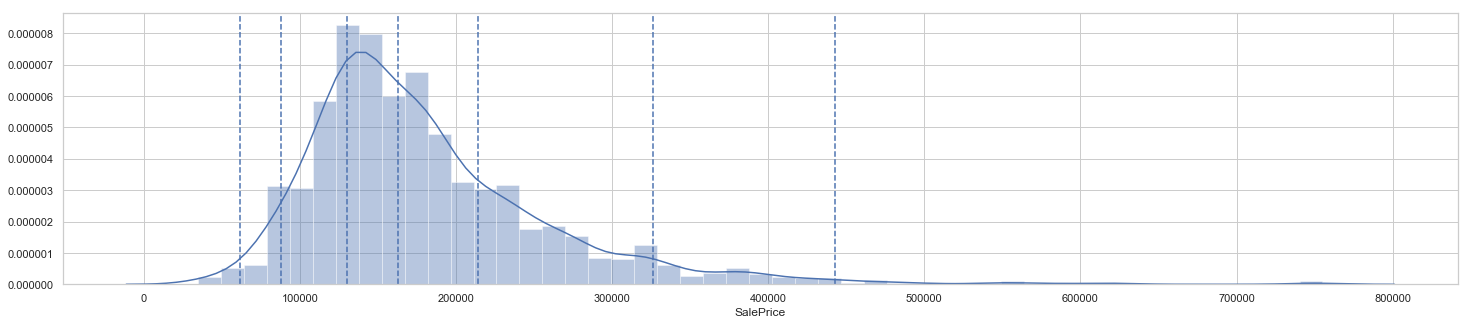

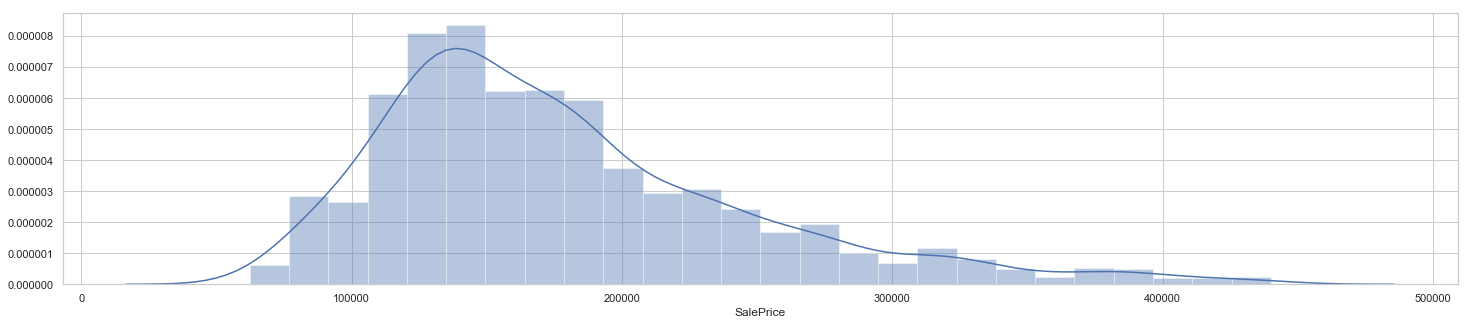

In [3]:
f, ax = plt.subplots(1,1,figsize=(25,5))
g = sns.distplot(a=data["SalePrice"], ax=ax)
for p in [1, 5, 25, 50, 75, 95, 99]:
    l = g.axvline(np.percentile(data["SalePrice"], p), linestyle="--")
# filter out the values >99 percentile and <1 percentile
data = data[(data["SalePrice"]<np.percentile(data["SalePrice"], 99)) & (data["SalePrice"]>np.percentile(data["SalePrice"], 1))]
f, ax = plt.subplots(1,1,figsize=(25,5))
g = sns.distplot(a=data["SalePrice"], ax=ax)

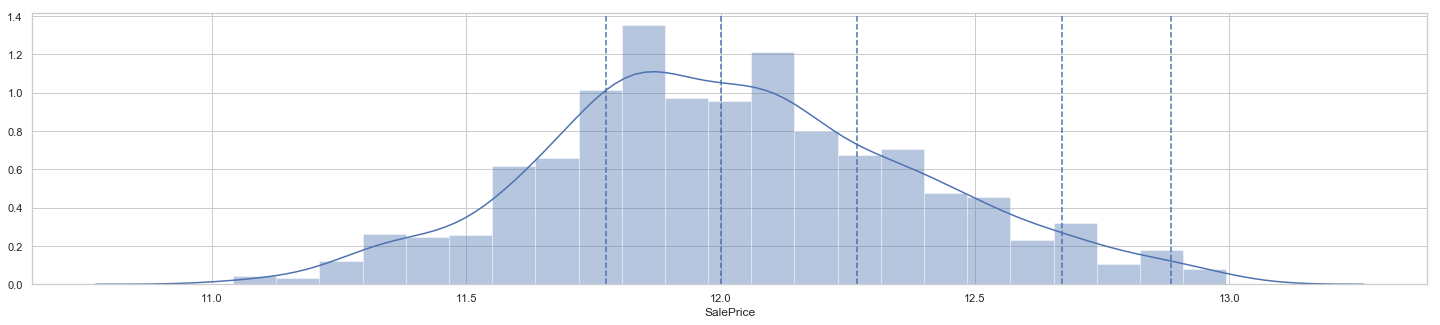

In [4]:
data["SalePrice"] = np.log1p(data["SalePrice"])
f, ax = plt.subplots(1,1,figsize=(25,5))
g = sns.distplot(a=data["SalePrice"], ax=ax)
for p in [25, 50, 75, 95, 99]:
    l = g.axvline(np.percentile(data["SalePrice"], p), linestyle="--")

In [5]:
ycol = ["SalePrice"]

In [6]:
obj_cols = [t for t in data.columns if ((data[t].dtype!=np.int64) and (data[t].dtype!=np.float64))]
numerical_cols = [t for t in data.columns if (t not in obj_cols + ycol)]
display(
data[obj_cols].head(),
data[numerical_cols].head())

,col_MSZoning,col_Street,col_LotShape,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_ExterQual,col_ExterCond,col_Foundation,col_BsmtQual,col_BsmtCond,col_BsmtExposure,col_BsmtFinType1,col_BsmtFinType2,col_Heating,col_HeatingQC,col_CentralAir,col_Electrical,col_KitchenQual,col_Functional,col_FireplaceQu,col_GarageType,col_GarageFinish,col_GarageQual,col_GarageCond,col_PavedDrive,col_SaleType,col_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


,col_MSSubClass,col_LotFrontage,col_LotArea,col_OverallQual,col_OverallCond,col_YearBuilt,col_YearRemodAdd,col_MasVnrArea,col_BsmtFinSF1,col_BsmtFinSF2,col_BsmtUnfSF,col_TotalBsmtSF,col_1stFlrSF,col_2ndFlrSF,col_LowQualFinSF,col_GrLivArea,col_BsmtFullBath,col_BsmtHalfBath,col_FullBath,col_HalfBath,col_BedroomAbvGr,col_KitchenAbvGr,col_TotRmsAbvGrd,col_Fireplaces,col_GarageYrBlt,col_GarageCars,col_GarageArea,col_WoodDeckSF,col_OpenPorchSF,col_EnclosedPorch,col_3SsnPorch,col_ScreenPorch,col_PoolArea,col_MiscVal,col_MoSold,col_YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [7]:
# f, ax = plt.subplots(1,1,figsize=(30,30))
# plot_corr_heatmap(np.round(data[numerical_cols + ycol].corr(),2), ax=ax, annotate=True, annot_size=12)

In [8]:
drop_cols = ["col_GarageCars", "col_TotRmsAbvGrd", "col_1stFlrSF", "col_GarageYrBlt"]

for dc in drop_cols:
    if dc in data:
        data.drop(dc, axis=1, inplace=True)
        
# update numerical columns as well
numerical_cols = [t for t in numerical_cols if t in data.columns]
data.shape    

(1430, 72)

In [9]:
# f, ax = plt.subplots(1,1,figsize=(30,30))
# plot_corr_heatmap(np.round(data[numerical_cols + ycol].corr(),2), ax=ax, annotate=True, annot_size=12)

In [10]:
data.to_csv("./train_corr_removed.csv")

#  Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)
data_train[obj_cols].head()

,col_MSZoning,col_Street,col_LotShape,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_ExterQual,col_ExterCond,col_Foundation,col_BsmtQual,col_BsmtCond,col_BsmtExposure,col_BsmtFinType1,col_BsmtFinType2,col_Heating,col_HeatingQC,col_CentralAir,col_Electrical,col_KitchenQual,col_Functional,col_FireplaceQu,col_GarageType,col_GarageFinish,col_GarageQual,col_GarageCond,col_PavedDrive,col_SaleType,col_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
583,RL,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,SFoyer,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,Gd,CBlock,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,WD,Normal
826,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,BrkFace,Ex,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,New,Partial
1257,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,PConc,Gd,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,WD,Normal
596,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,Other,BrkFace,Gd,TA,PConc,Gd,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,Fin,TA,TA,Y,New,Partial
1419,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,TA,TA,No,BLQ,Rec,GasA,TA,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,Y,COD,Normal


In [13]:
# Encode some categorical features as ordered numbers when there is information in the order
# Plagiarized from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset 
custom_encoder = {
    "col_BsmtCond" :     {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
    "col_BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "col_BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "col_BsmtQual" :     {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
    "col_ExterCond" :    {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
    "col_ExterQual" :    {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
    "col_FireplaceQu" :  {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_GarageCond" :   {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_GarageQual" :   {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_HeatingQC" :    {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_KitchenQual" :  {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "col_LotShape" :     {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "col_PavedDrive" :   {"N" : 0, "P" : 1, "Y" : 2},
 }
data_train = data_train.replace(custom_encoder)

What are the remaining columns we need to encode? 

In [14]:
obj_cols2 = [t for t in obj_cols if data_train[t].dtype==object]

In [15]:
data_train[obj_cols2].head()

,col_MSZoning,col_Street,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_Foundation,col_Heating,col_CentralAir,col_Electrical,col_Functional,col_GarageType,col_GarageFinish,col_SaleType,col_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,
583,RL,Grvl,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,SFoyer,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,SBrkr,Typ,Attchd,Unf,WD,Normal
826,RL,Pave,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,New,Partial
1257,RL,Pave,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,WD,Normal
596,RL,Pave,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,Other,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,New,Partial
1419,RL,Pave,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,CBlock,GasA,Y,SBrkr,Typ,Detchd,Unf,COD,Normal


In [16]:
# Label Encode the data
cols_to_labelencode = [c for c in data_train.columns if c in obj_cols2]
display(data_train[cols_to_labelencode].head())
data_train, lencoder_dict= labelencode_collist(data_train, cols_to_labelencode)
display(data_train[cols_to_labelencode].head())

,col_MSZoning,col_Street,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_Foundation,col_Heating,col_CentralAir,col_Electrical,col_Functional,col_GarageType,col_GarageFinish,col_SaleType,col_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,
583,RL,Grvl,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,SFoyer,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,SBrkr,Typ,Attchd,Unf,WD,Normal
826,RL,Pave,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,New,Partial
1257,RL,Pave,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,WD,Normal
596,RL,Pave,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,Other,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Fin,New,Partial
1419,RL,Pave,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,CBlock,GasA,Y,SBrkr,Typ,Detchd,Unf,COD,Normal


,col_MSZoning,col_Street,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_Foundation,col_Heating,col_CentralAir,col_Electrical,col_Functional,col_GarageType,col_GarageFinish,col_SaleType,col_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,
583,3,0,3,0,4,0,7,2,2,2,6,1,1,5,6,1,1,0,1,3,6,1,2,8,4
826,3,1,3,0,4,0,16,4,4,0,2,3,1,4,5,1,2,0,1,3,6,1,0,6,5
1257,3,1,3,0,0,0,15,2,2,0,2,3,1,5,6,1,2,0,1,3,6,1,0,8,4
596,3,1,3,0,4,0,22,2,2,0,2,1,1,11,9,1,2,0,1,3,6,1,0,6,5
1419,3,1,3,0,4,0,12,2,2,0,2,1,1,5,6,2,1,0,1,3,6,5,2,0,4


### Apply the Encoding to the test data set as well 

In [17]:
# Repeat the same for the test data
# Check if the test data contains labels that we could not observe in the train data
for colname, encmap in custom_encoder.items():
    # Quick failsafe to handle unseen labels
    for lblname in data_test[colname].unique():
        if lblname not in encmap:
            custom_encoder[colname][lblname] = -1
            
# Encode the dataframe
data_test = data_test.replace(custom_encoder)

In [18]:
# Repeat the same for the test data
# Check if the test data contains labels that we could not observe in the train data
for colname, encmap in lencoder_dict.items():
    # Quick failsafe to handle unseen labels
    for lblname in data_test[colname].unique():
        if lblname not in encmap:
            lencoder_dict[colname][lblname] = -1
            
# Encode the dataframe
data_test = data_test.replace(lencoder_dict)

-----------------------

In [19]:
display(
    data_train.head(),
    data_test.head()
)

,col_MSSubClass,col_MSZoning,col_LotFrontage,col_LotArea,col_Street,col_LotShape,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_OverallQual,col_OverallCond,col_YearBuilt,col_YearRemodAdd,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_MasVnrArea,col_ExterQual,col_ExterCond,col_Foundation,col_BsmtQual,col_BsmtCond,col_BsmtExposure,col_BsmtFinType1,col_BsmtFinSF1,col_BsmtFinType2,col_BsmtFinSF2,col_BsmtUnfSF,col_TotalBsmtSF,col_Heating,col_HeatingQC,col_CentralAir,col_Electrical,col_2ndFlrSF,col_LowQualFinSF,col_GrLivArea,col_BsmtFullBath,col_BsmtHalfBath,col_FullBath,col_HalfBath,col_BedroomAbvGr,col_KitchenAbvGr,col_KitchenQual,col_Functional,col_Fireplaces,col_FireplaceQu,col_GarageType,col_GarageFinish,col_GarageArea,col_GarageQual,col_GarageCond,col_PavedDrive,col_WoodDeckSF,col_OpenPorchSF,col_EnclosedPorch,col_3SsnPorch,col_ScreenPorch,col_PoolArea,col_MiscVal,col_MoSold,col_YrSold,col_SaleType,col_SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
583,90,3,81.0,11841,0,4,3,0,4,0,7,2,2,2,6,6,5,1990,1990,1,1,5,6,1,104.0,3,4,1,4,3,2,6,816,1,0,0,816,0,3,1,3,0,0,816,1,0,1,0,3,1,3,6,0,0,1,2,0,3,3,2,0,32,0,0,0,0,0,5,2007,8,4,11.682677
826,20,3,114.0,14803,1,4,3,0,4,0,16,4,4,0,2,10,5,2007,2008,3,1,4,5,1,816.0,5,3,2,5,3,2,6,1636,1,0,442,2078,0,5,1,3,0,0,2084,1,0,2,0,2,1,5,6,1,4,1,0,1220,3,3,2,188,45,0,0,0,0,0,6,2008,6,5,12.861001
1257,20,3,91.0,14303,1,3,3,0,0,0,15,2,2,0,2,8,5,1994,1994,3,1,5,6,1,554.0,4,3,2,4,3,3,6,1314,1,0,672,1986,0,5,1,3,0,0,1987,1,0,2,0,2,1,4,6,1,3,1,0,691,3,3,2,262,36,0,0,0,0,0,8,2008,8,4,12.616529
596,20,3,69.0,11302,1,3,3,0,4,0,22,2,2,0,2,8,5,2005,2006,1,1,11,9,1,238.0,4,3,2,4,3,3,6,1422,1,0,392,1814,0,5,1,3,0,0,1826,1,0,2,0,3,1,4,6,1,3,1,0,758,3,3,2,180,75,0,0,120,0,0,8,2006,6,5,12.672950
1419,20,3,71.0,9204,1,4,3,0,4,0,12,2,2,0,2,5,5,1963,1963,1,1,5,6,2,0.0,3,3,1,3,3,0,4,25,3,872,247,1144,0,3,1,3,0,0,1144,1,0,1,1,3,1,3,6,0,0,5,2,336,3,3,2,0,88,0,0,0,0,0,8,2008,0,4,11.728045


,col_MSSubClass,col_MSZoning,col_LotFrontage,col_LotArea,col_Street,col_LotShape,col_LandContour,col_Utilities,col_LotConfig,col_LandSlope,col_Neighborhood,col_Condition1,col_Condition2,col_BldgType,col_HouseStyle,col_OverallQual,col_OverallCond,col_YearBuilt,col_YearRemodAdd,col_RoofStyle,col_RoofMatl,col_Exterior1st,col_Exterior2nd,col_MasVnrType,col_MasVnrArea,col_ExterQual,col_ExterCond,col_Foundation,col_BsmtQual,col_BsmtCond,col_BsmtExposure,col_BsmtFinType1,col_BsmtFinSF1,col_BsmtFinType2,col_BsmtFinSF2,col_BsmtUnfSF,col_TotalBsmtSF,col_Heating,col_HeatingQC,col_CentralAir,col_Electrical,col_2ndFlrSF,col_LowQualFinSF,col_GrLivArea,col_BsmtFullBath,col_BsmtHalfBath,col_FullBath,col_HalfBath,col_BedroomAbvGr,col_KitchenAbvGr,col_KitchenQual,col_Functional,col_Fireplaces,col_FireplaceQu,col_GarageType,col_GarageFinish,col_GarageArea,col_GarageQual,col_GarageCond,col_PavedDrive,col_WoodDeckSF,col_OpenPorchSF,col_EnclosedPorch,col_3SsnPorch,col_ScreenPorch,col_PoolArea,col_MiscVal,col_MoSold,col_YrSold,col_SaleType,col_SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
125,20,3,48.0,17043,1,3,3,0,1,0,14,2,2,0,2,6,5,1979,1998,1,1,5,6,2,0.0,3,4,1,4,2,0,1,0,1,0,1362,1362,0,3,1,3,0,0,1586,0,0,2,0,3,1,3,6,1,3,1,2,435,3,3,2,192,0,0,0,0,0,0,1,2009,8,4,12.106258
1216,20,3,99.0,7094,1,3,3,0,4,0,19,2,2,0,2,5,5,1966,1966,1,1,11,13,2,0.0,3,3,1,3,3,0,3,180,2,374,340,894,0,3,1,3,0,0,894,0,0,1,0,3,1,3,6,0,0,5,1,384,3,3,2,0,0,0,0,0,0,0,5,2007,8,4,11.736077
469,20,3,98.0,11428,1,3,3,0,4,0,16,2,2,0,2,8,5,2006,2006,1,1,11,13,3,248.0,4,3,2,4,3,0,1,0,1,0,1626,1626,0,5,1,3,0,0,1634,0,0,2,0,3,1,4,6,1,4,1,1,866,3,3,2,0,44,0,0,0,0,0,5,2007,8,4,12.429220
355,50,3,60.0,8400,1,4,0,0,4,0,18,2,2,0,0,6,5,1940,2000,1,1,12,8,2,0.0,3,3,1,3,3,0,2,388,1,0,552,940,0,5,1,3,403,0,1595,0,0,1,0,2,1,3,6,2,4,1,2,240,3,3,2,0,0,108,0,0,0,0,6,2006,8,4,11.849405
1031,190,2,69.0,7082,1,4,3,0,4,0,18,2,2,1,5,5,8,1916,1995,1,1,11,13,2,0.0,3,3,2,3,3,1,1,0,1,0,686,686,0,4,1,3,980,0,1928,0,0,2,0,5,2,3,6,0,0,1,2,0,3,3,0,0,0,228,0,0,0,0,7,2006,8,4,11.982935


---------------------------------

# Random Forest Regression

In [38]:
ycol = ["SalePrice"]
xcol = [t for t in data_train.columns if t not in ycol]

d:\softwares\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Train set RMSE Scaled: 0.06
Test set RMSE Scaled: 0.13


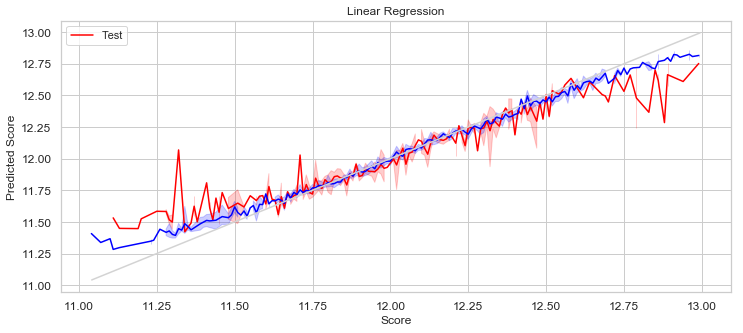

In [39]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=80, min_samples_leaf=1, max_depth=10, max_features="sqrt")
rfr = rfr.fit(data_train[xcol].values, data_train[ycol].values)

xcol = [c for c in data_train if "SalePrice" not in c]
y_pred_train = rfr.predict(data_train[xcol])
y_pred_test = rfr.predict(data_test[xcol])
y_train = data_train["SalePrice"]
y_test = data_test["SalePrice"]

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.2f}".format(rmse_train))
print("Test set RMSE Scaled: {:.2f}".format(rmse_test))

f, ax = plt.subplots(1,1, figsize=(12, 5), sharex=False)
g = sns.lineplot(x=np.round(y_test.values.ravel(),2), y=y_pred_test.ravel(), ax=ax, color="red")
g = sns.lineplot(x=np.round(y_train.values.ravel(),2), y=y_pred_train.ravel(), ax=ax, color="blue")
g = sns.lineplot(x=[np.min(y_train),np.max(y_train)], y=[np.min(y_train),np.max(y_train)], ax=ax, color="lightgrey")
t = g.set_xlabel("Score")
t = g.set_ylabel("Predicted Score")
t = g.set_title("Linear Regression")
l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Test","Train"])
t = g.tick_params(labelsize=12)

-----------------------------------

# Linear Regression

'SalePrice ~ col_MSSubClass + col_MSZoning + col_LotFrontage + col_LotArea + col_Street + col_LotShape + col_LandContour + col_Utilities + col_LotConfig + col_LandSlope + col_Neighborhood + col_Condition1 + col_Condition2 + col_BldgType + col_HouseStyle + col_OverallQual + col_OverallCond + col_YearBuilt + col_YearRemodAdd + col_RoofStyle + col_RoofMatl + col_Exterior1st + col_Exterior2nd + col_MasVnrType + col_MasVnrArea + col_ExterQual + col_ExterCond + col_Foundation + col_BsmtQual + col_BsmtCond + col_BsmtExposure + col_BsmtFinType1 + col_BsmtFinSF1 + col_BsmtFinType2 + col_BsmtFinSF2 + col_BsmtUnfSF + col_TotalBsmtSF + col_Heating + col_HeatingQC + col_CentralAir + col_Electrical + col_2ndFlrSF + col_LowQualFinSF + col_GrLivArea + col_BsmtFullBath + col_BsmtHalfBath + col_FullBath + col_HalfBath + col_BedroomAbvGr + col_KitchenAbvGr + col_KitchenQual + col_Functional + col_Fireplaces + col_FireplaceQu + col_GarageType + col_GarageFinish + col_GarageArea + col_GarageQual + col_Gara

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     99.61
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:12:07   Log-Likelihood:                 639.04
No. Observations:                1001   AIC:                            -1138.
Df Residuals:                     931   BIC:                            -794.5
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            19.7933      6.69

d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
d:\softwares\python36\lib\site-packages\matplotlib\cbook\__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


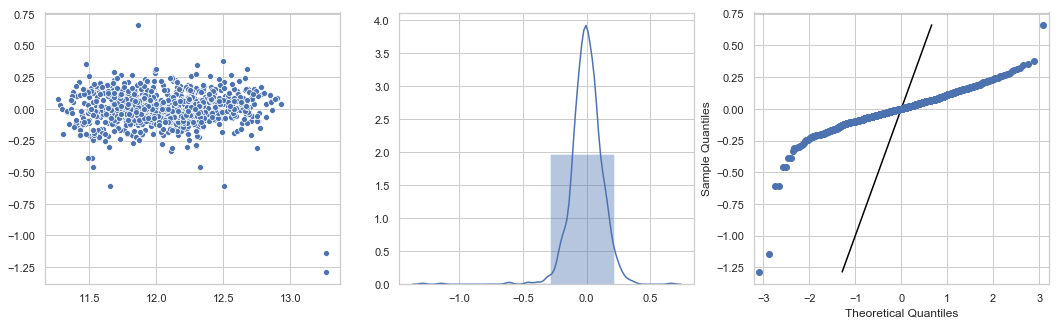

In [22]:
# Use Statsmodels
formula = "SalePrice ~" 
cols_sm = [c for c in data_train.columns if c not in ["SalePrice"]]
for c in cols_sm:
    if formula[-1] == "~":
        formula += " " + c
    else:
        formula +=  " + " + c
        
display(formula)
        
result = smfapi.ols(formula=formula, data=data_train).fit()
print (result.summary())
residuals = result.resid

f, ax = plt.subplots(1,3,figsize=(18,5))
g = sns.scatterplot(x=result.fittedvalues, y=residuals, ax=ax[0])
g = sns.distplot(residuals, bins=np.arange(min(residuals), max(residuals), 0.5), ax=ax[1])
# MAke a QQ plot of residuals
x = np.linspace(np.min(residuals),np.max(residuals),len(residuals))
g = sns.lineplot(x=x, y=x, ax=ax[2], c="black")
g = smapi.qqplot(residuals, ax=ax[2])


# Test for normality of residuals
print("\n")
print(80*"-")
print("Shapiro test results : ")
np.random.seed(42)
w, pval = stats.shapiro(residuals)
print("pval :", pval)
if pval < 0.05:
    print("Null hypo rejected - Data is not normally  distributed")
else:
    print("Data is normally distributed")

### Run the model on the test data set

In [41]:
y_train = data_train["SalePrice"]
y_test = data_test["SalePrice"]
y_pred_train = result.predict(data_train)
y_pred_test = result.predict(data_test)

mse_train = MSE(y_train, y_pred_train)
mse_test = MSE(y_test, y_pred_test)

rmse_train = mse_train**(1/2)
rmse_test = mse_test**(1/2)

print("Train set RMSE Scaled: {:.3f}".format(rmse_train))
print("Test set RMSE Scaled: {:.3f}".format(rmse_test))

Train set RMSE Scaled: 0.128
Test set RMSE Scaled: 0.130


In [42]:
from statsmodels.stats.diagnostic import het_breuschpagan
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals,x_train)
print('the p-value for the lagrange multiplier test statistic is %f' % (lm_pvalue))
if lm_pvalue < 0.05:
    print("Null hypothesis rejected - Heteroskedasticity")
else:
    print("Alternate hypothesis rejected - Homoskedasticity")

the p-value for the lagrange multiplier test statistic is 0.000000
Null hypothesis rejected - Heteroskedasticity


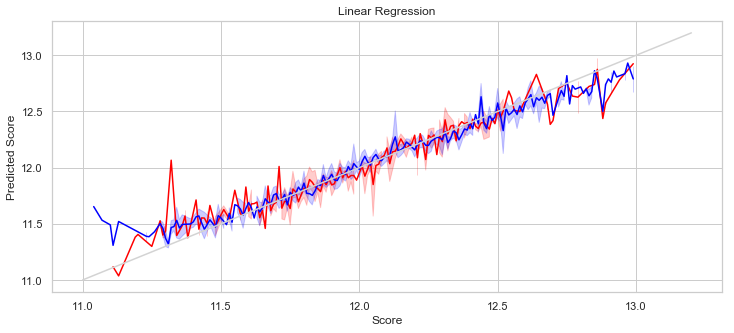

In [32]:
f, ax = plt.subplots(1,1, figsize=(12, 5), sharex=False)
g = sns.lineplot(x=np.round(y_test.values.ravel(),2), y=y_pred_test.ravel(), ax=ax, color="red")
g = sns.lineplot(x=np.round(y_train.values.ravel(),2), y=y_pred_train.ravel(), ax=ax, color="blue")
g = sns.lineplot(x=[11,13.2], y=[11,13.2], ax=ax, color="lightgrey")
t = g.set_xlabel("Score")
t = g.set_ylabel("Predicted Score")
# t = g.set_xticklabels(g.get_xticklabels(), rotation=90)
t = g.set_title("Linear Regression")
# l = ax.legend(handles=ax.lines[::len(np.unique(y_train))+1], labels=["Test","Train"])